This is my first model of this competition.  
My first choice is LightGBM.  
In this kernel I use other kaggler's features, my own feature engineering is next step.  
  
Ref:https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model

I had posted my very naive baseline at https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019. In that kernel I only used the mode label for each Assessment and I thought it should be very easy to beat. This kernel shows how you can beat that baseline by actually applying a model. In this kernel via `get_data()` function, I go over each `installation_id` and try to extract some features based on his/her behavior prior to the assessment. I will then train a `Catboost` classifier on it and make predictions on the test set. Note that the features I made in this kernel are so very basic and you can easily add many more to it. Good luck and happy kaggling. Don't forget to upvote if you found it useful ;)

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
#from catboost import CatBoostClassifier
from time import time
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.metrics import confusion_matrix
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
        
    return 1-np.divide(num,den)
    

In [3]:
train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')

In [4]:
#train_labels.head()

In [5]:
#train.shape

In [6]:
#test.shape

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# encode title column
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

In [8]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,25,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,31,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,17,Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,17,Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,17,Activity,MAGMAPEAK


In [9]:
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [10]:
#print(win_code)

In [11]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [12]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,25,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,31,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,17,Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06 17:54:56.387000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,17,Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06 17:55:03.253000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,17,Activity,MAGMAPEAK


In [13]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    for i, session in user_sample.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        if test_set == True:
            second_condition = True
        else:
            if len(session)>1:
                second_condition = True
            else:
                second_condition= False
            
        if (session_type == 'Assessment') & (second_condition):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            features = user_activities_count.copy()
    #         features['installation_id'] = session['installation_id'].iloc[0]
#             features['game_session'] = i
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1

            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
            if test_set == True:
                all_assessments.append(features)
            else:
                if true_attempts+false_attempts > 0:
                    all_assessments.append(features)
                
            counter += 1

    #         break

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

    if test_set:
        return all_assessments[-1] 
    return all_assessments

In [14]:
compiled_data = []
for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False), total=17000):
    compiled_data += get_data(user_sample)

In [15]:
new_train = pd.DataFrame(compiled_data)
del compiled_data
new_train.shape

(17690, 16)

In [16]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
new_test = pd.DataFrame(new_test)
#del test

In [17]:
del train
del test

In [18]:
new_train.shape

(17690, 16)

In [19]:
new_test["accuracy_group"].unique()

array([0])

In [20]:
new_test = new_test.drop(["accuracy_group"], axis=1)
new_test.shape

(1000, 15)

Below are the features I have generated. Note that all of them are **prior** to each event. For example, the first row shows **before** this assessment, the player have watched 3 clips, did 3 activities, played 4 games and solved 0 assessments, so on so forth.

## Model

In [21]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
from sklearn import metrics
import time
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import gc
import warnings
warnings.filterwarnings("ignore")

In [22]:
#add type
new_train["type"]=1
new_test["type"]=1
new_test.head()

,Clip,Activity,Assessment,Game,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions,type
0,14,7,1,3,35,1,0,30.000000000000000,1.000000000000000,0,0,0,1,3.0,867,1
1,29,11,5,12,40,4,7,49.600000000000001,0.466666666666667,1,1,2,1,1.6,2718,1
2,6,2,0,0,29,0,0,0.000000000000000,0.000000000000000,0,0,0,0,0.0,149,1
3,10,2,0,1,29,0,0,0.000000000000000,0.000000000000000,0,0,0,0,0.0,233,1
4,17,1,0,6,40,0,0,0.000000000000000,0.000000000000000,0,0,0,0,0.0,951,1


In [23]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [24]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [25]:
def del_cols(df, cols):
    del_cols_list_ = [l for l in cols if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

y_train = new_train["accuracy_group"]
x_train = del_cols(new_train, ["accuracy_group"])
x_test = new_test
x_train.head(5)

,Clip,Activity,Assessment,Game,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions,type
0,11,3,0,4,29,0,0,0.000000000000000,0.0,0,0,0,0,0.0,647,1
1,14,4,1,6,36,1,0,39.000000000000000,1.0,0,0,0,1,3.0,1143,1
2,14,4,2,6,29,1,11,65.500000000000000,0.5,1,0,0,1,1.5,1230,1
3,24,9,4,10,29,2,11,41.250000000000000,0.5,2,0,0,2,1.5,2159,1
4,28,10,5,13,36,3,12,39.200000000000003,0.5,2,0,1,2,1.6,2586,1


In [26]:
#y_train = new_train["accuracy_group"]
len(y_train)

17690

In [27]:
import optuna

In [28]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [29]:
X_short = pd.DataFrame({'ind': list(new_train.index), 
                        'type': new_train['type'].values,
                        'oof': [0] * len(new_train), 
                        'target': y_train.values})
X_short_test = pd.DataFrame({'ind': list(new_test.index), 
                             'type': new_test['type'].values, 
                             'prediction': [0] * len(new_test)})

In [33]:
n_estimators = [2000]

# Optimize hyper parameters using by Optuna

In [34]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 9)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 5, 200)
    verbosity = trial.suggest_int('verbosity', -1, 1)
    #num_boost_round = trial.suggest_int('num_boost_round', 10, 100000)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 500)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 500)
    boosting_type = trial.suggest_categorical('boosting', ["gbdt", "dart","goss"])

    params = {'num_leaves': num_leaves,
          'min_child_samples': min_child_samples,
          'objective': 'regression',  #I will check it.
          'max_depth': max_depth,
          'learning_rate': learning_rate,
          "boosting_type": boosting_type,
          "max_bin":64, 
          "min_data_in_leaf":min_data_in_leaf,
          "subsample_freq": 1,
          "subsample": subsample,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": verbosity,
          #'reg_alpha': 0.8,
          #'reg_lambda': 0.2,
          #'colsample_bytree': 0.6
          'lambda_l1': 0.8,
          'lambda_l2': 0.2,
          'feature_fraction': 0.9,
         }

    #Run
    CV_score = 0

    for t in new_train['type'].unique():
        type_ = t
        print(f'\nTraining of type {t}: {type_}.')
        index_type = (new_train['type'] == t)
        index_type_test = (new_test['type'] == t)
    
        X_t = x_train.loc[index_type].copy()
        X_test_t = x_test.loc[index_type_test].copy()
        y_t = y_train[index_type]

    
        result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                                  y=y_t, params=params, 
                                                  folds=folds, 
                                                  model_type='lgb', 
                                                  eval_metric='mae', 
                                                  plot_feature_importance=True,
                                                  verbose=500, early_stopping_rounds=200, 
                                                  n_estimators=n_estimators[t-1])
        del X_t, X_test_t
        gc.collect()
    
        X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
        X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
        
        ## manually computing the cv score
        CV_score += np.log(np.array(result_dict_lgb['scores']).mean())/8 # total 8 types
        
        result = pd.DataFrame({"y_train":new_train["accuracy_group"],
                      "y_pred":result_dict_lgb['oof']})
        result["y_pred"]= np.round(result.y_pred).astype('int')
        from sklearn.metrics import confusion_matrix, cohen_kappa_score
        kappa = cohen_kappa_score(result.y_train, result.y_pred, weights='quadratic')
    
    return -kappa


Training of type 1: 1.
Fold 1 started at Wed Nov  6 10:51:01 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's l1: 0.787878	valid_1's l1: 0.840219
Fold 2 started at Wed Nov  6 10:51:02 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's l1: 0.809305	valid_1's l1: 0.858375
Fold 3 started at Wed Nov  6 10:51:03 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's l1: 0.83217	valid_1's l1: 0.833631
Fold 4 started at Wed Nov  6 10:51:03 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's l1: 0.827344	valid_1's l1: 0.878842
Fold 5 started at Wed Nov  6 10:51:04 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's l1: 0.819717	valid_1's l1: 0.860857
Fold 6 started at 

[I 2019-11-06 10:51:09,235] Finished trial#0 resulted in value: -0.4745232704946879. Current best value is -0.4745232704946879 with parameters: {'max_depth': 5, 'feature_fraction': 0.3058830425173462, 'learning_rate': 0.8141481026749143, 'subsample': 0.8025647293945135, 'num_leaves': 88, 'verbosity': 1, 'min_data_in_leaf': 230, 'min_child_samples': 142, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 10:51:09 2019


[W 2019-11-06 10:51:09,307] Setting status of trial#1 as TrialState.FAIL because of the following error: LightGBMError('Cannot use bagging in GOSS',)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/optuna/study.py", line 505, in _run_trial
    result = func(trial)
  File "<ipython-input-34-056bebba6e2c>", line 55, in objective
    n_estimators=n_estimators[t-1])
  File "<ipython-input-23-7f770cb83d7f>", line 60, in train_model_regression
    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/sklearn.py", line 738, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/sklearn.py", line 595, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py", line 1666, in __init__
 


Training of type 1: 1.
Fold 1 started at Wed Nov  6 10:51:09 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[173]	training's l1: 0.726972	valid_1's l1: 0.835817
Fold 2 started at Wed Nov  6 10:51:10 2019
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.620908	valid_1's l1: 0.849881
Early stopping, best iteration is:
[303]	training's l1: 0.67574	valid_1's l1: 0.840982
Fold 3 started at Wed Nov  6 10:51:11 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[199]	training's l1: 0.716947	valid_1's l1: 0.827531
Fold 4 started at Wed Nov  6 10:51:12 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's l1: 0.755719	valid_1's l1: 0.863418
Fold 5 started at Wed Nov  6 10:51:13 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	traini

[I 2019-11-06 10:51:21,386] Finished trial#2 resulted in value: -0.4852817286359832. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 10:51:21 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's l1: 0.77354	valid_1's l1: 0.842007
Fold 2 started at Wed Nov  6 10:51:22 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's l1: 0.785274	valid_1's l1: 0.865824
Fold 3 started at Wed Nov  6 10:51:22 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's l1: 0.796399	valid_1's l1: 0.82778
Fold 4 started at Wed Nov  6 10:51:23 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's l1: 0.800104	valid_1's l1: 0.866584
Fold 5 started at Wed Nov  6 10:51:24 2019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's l1: 0.796075	valid_1's l1: 0.860454
Fold 6 started at 

[I 2019-11-06 10:51:29,197] Finished trial#3 resulted in value: -0.4774914250566593. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 10:51:29 2019
[500]	training's l1: 0.706468	valid_1's l1: 0.871511
[1000]	training's l1: 0.66407	valid_1's l1: 0.888153
[1500]	training's l1: 0.635851	valid_1's l1: 0.890376
[2000]	training's l1: 0.605109	valid_1's l1: 0.899798
Fold 2 started at Wed Nov  6 10:52:25 2019
[500]	training's l1: 0.707283	valid_1's l1: 0.875879
[1000]	training's l1: 0.66525	valid_1's l1: 0.880661
[1500]	training's l1: 0.629965	valid_1's l1: 0.90118
[2000]	training's l1: 0.601502	valid_1's l1: 0.914069
Fold 3 started at Wed Nov  6 10:53:19 2019
[500]	training's l1: 0.706057	valid_1's l1: 0.849728
[1000]	training's l1: 0.662218	valid_1's l1: 0.86442
[1500]	training's l1: 0.634808	valid_1's l1: 0.887987
[2000]	training's l1: 0.600728	valid_1's l1: 0.90484
Fold 4 started at Wed Nov  6 10:54:18 2019
[500]	training's l1: 0.700561	valid_1's l1: 0.904032
[1000]	training's l1: 0.654969	valid_1's l1: 0.92511
[1500]	training's l1: 0.626334	valid_1's l1: 0.941318
[200

[I 2019-11-06 11:00:43,415] Finished trial#4 resulted in value: -0.4463339361643154. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 11:00:43 2019
[500]	training's l1: 0.702789	valid_1's l1: 0.839879
[1000]	training's l1: 0.652656	valid_1's l1: 0.839226
[1500]	training's l1: 0.612888	valid_1's l1: 0.847462
[2000]	training's l1: 0.572839	valid_1's l1: 0.850767
Fold 2 started at Wed Nov  6 11:01:59 2019
[500]	training's l1: 0.703106	valid_1's l1: 0.844877
[1000]	training's l1: 0.651362	valid_1's l1: 0.84948
[1500]	training's l1: 0.60833	valid_1's l1: 0.857444
[2000]	training's l1: 0.569978	valid_1's l1: 0.858319
Fold 3 started at Wed Nov  6 11:03:16 2019
[500]	training's l1: 0.703985	valid_1's l1: 0.82622
[1000]	training's l1: 0.650251	valid_1's l1: 0.83068
[1500]	training's l1: 0.612564	valid_1's l1: 0.832759
[2000]	training's l1: 0.571359	valid_1's l1: 0.835989
Fold 4 started at Wed Nov  6 11:04:34 2019
[500]	training's l1: 0.698559	valid_1's l1: 0.871993
[1000]	training's l1: 0.646169	valid_1's l1: 0.878358
[1500]	training's l1: 0.606266	valid_1's l1: 0.885027
[2

[I 2019-11-06 11:13:31,039] Finished trial#5 resulted in value: -0.4799267104363363. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 11:13:31 2019
[500]	training's l1: 0.765006	valid_1's l1: 0.84279
[1000]	training's l1: 0.738873	valid_1's l1: 0.843957
[1500]	training's l1: 0.719807	valid_1's l1: 0.846995
[2000]	training's l1: 0.696471	valid_1's l1: 0.860683
Fold 2 started at Wed Nov  6 11:14:11 2019
[500]	training's l1: 0.765801	valid_1's l1: 0.862143
[1000]	training's l1: 0.735604	valid_1's l1: 0.864765
[1500]	training's l1: 0.713047	valid_1's l1: 0.876925
[2000]	training's l1: 0.694996	valid_1's l1: 0.874975
Fold 3 started at Wed Nov  6 11:14:52 2019
[500]	training's l1: 0.765895	valid_1's l1: 0.83605
[1000]	training's l1: 0.738868	valid_1's l1: 0.843911
[1500]	training's l1: 0.721611	valid_1's l1: 0.849016
[2000]	training's l1: 0.698426	valid_1's l1: 0.860889
Fold 4 started at Wed Nov  6 11:15:32 2019
[500]	training's l1: 0.762624	valid_1's l1: 0.87706
[1000]	training's l1: 0.730695	valid_1's l1: 0.888531
[1500]	training's l1: 0.713271	valid_1's l1: 0.907408
[

[I 2019-11-06 11:20:17,541] Finished trial#6 resulted in value: -0.46028342269868294. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 11:20:17 2019


[W 2019-11-06 11:20:17,624] Setting status of trial#7 as TrialState.FAIL because of the following error: LightGBMError('Cannot use bagging in GOSS',)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/optuna/study.py", line 505, in _run_trial
    result = func(trial)
  File "<ipython-input-34-056bebba6e2c>", line 55, in objective
    n_estimators=n_estimators[t-1])
  File "<ipython-input-23-7f770cb83d7f>", line 60, in train_model_regression
    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/sklearn.py", line 738, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/sklearn.py", line 595, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py", line 1666, in __init__
 


Training of type 1: 1.
Fold 1 started at Wed Nov  6 11:20:17 2019
[500]	training's l1: 0.717655	valid_1's l1: 0.860267
[1000]	training's l1: 0.677087	valid_1's l1: 0.87073
[1500]	training's l1: 0.649377	valid_1's l1: 0.876524
[2000]	training's l1: 0.622954	valid_1's l1: 0.885007
Fold 2 started at Wed Nov  6 11:21:02 2019
[500]	training's l1: 0.715153	valid_1's l1: 0.867364
[1000]	training's l1: 0.673509	valid_1's l1: 0.878129
[1500]	training's l1: 0.644118	valid_1's l1: 0.890154
[2000]	training's l1: 0.617753	valid_1's l1: 0.886611
Fold 3 started at Wed Nov  6 11:21:48 2019
[500]	training's l1: 0.710034	valid_1's l1: 0.83768
[1000]	training's l1: 0.677045	valid_1's l1: 0.855062
[1500]	training's l1: 0.646072	valid_1's l1: 0.870875
[2000]	training's l1: 0.618744	valid_1's l1: 0.866704
Fold 4 started at Wed Nov  6 11:22:35 2019
[500]	training's l1: 0.710185	valid_1's l1: 0.892419
[1000]	training's l1: 0.665623	valid_1's l1: 0.909373
[1500]	training's l1: 0.642703	valid_1's l1: 0.915863


[I 2019-11-06 11:27:57,202] Finished trial#8 resulted in value: -0.45319588310749526. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.



Training of type 1: 1.
Fold 1 started at Wed Nov  6 11:27:57 2019
[500]	training's l1: 0.717978	valid_1's l1: 0.849189
[1000]	training's l1: 0.676856	valid_1's l1: 0.862685
[1500]	training's l1: 0.647171	valid_1's l1: 0.869987
[2000]	training's l1: 0.614555	valid_1's l1: 0.874646
Fold 2 started at Wed Nov  6 11:28:50 2019
[500]	training's l1: 0.714718	valid_1's l1: 0.856816
[1000]	training's l1: 0.673819	valid_1's l1: 0.870436
[1500]	training's l1: 0.639647	valid_1's l1: 0.867707
[2000]	training's l1: 0.608803	valid_1's l1: 0.879414
Fold 3 started at Wed Nov  6 11:29:43 2019
[500]	training's l1: 0.71701	valid_1's l1: 0.834297
[1000]	training's l1: 0.676637	valid_1's l1: 0.850708
[1500]	training's l1: 0.64509	valid_1's l1: 0.851101
[2000]	training's l1: 0.614662	valid_1's l1: 0.859358
Fold 4 started at Wed Nov  6 11:30:37 2019
[500]	training's l1: 0.711763	valid_1's l1: 0.891941
[1000]	training's l1: 0.670953	valid_1's l1: 0.899501
[1500]	training's l1: 0.639468	valid_1's l1: 0.903897


[I 2019-11-06 11:36:50,476] Finished trial#9 resulted in value: -0.461573153098753. Current best value is -0.4852817286359832 with parameters: {'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}.


params_{'max_depth': 9, 'feature_fraction': 0.9837729192965413, 'learning_rate': 0.19449756501328536, 'subsample': 0.8416208474888902, 'num_leaves': 19, 'verbosity': -1, 'min_data_in_leaf': 40, 'min_child_samples': 314, 'boosting': 'gbdt'}
value_-0.4852817286359832


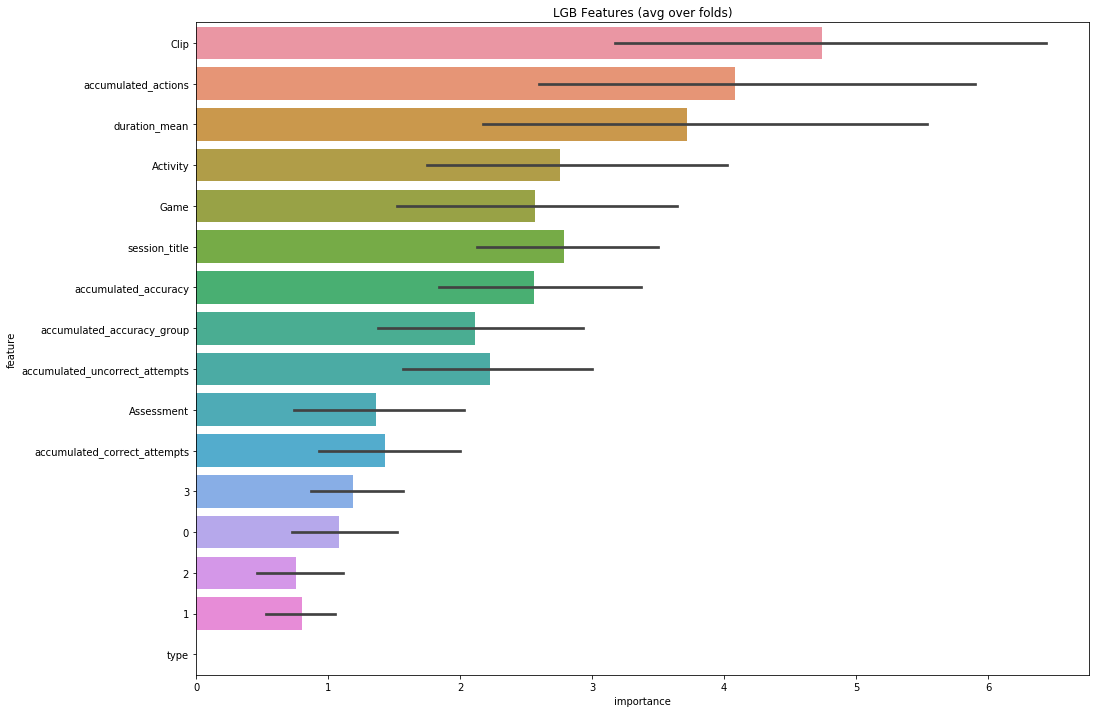

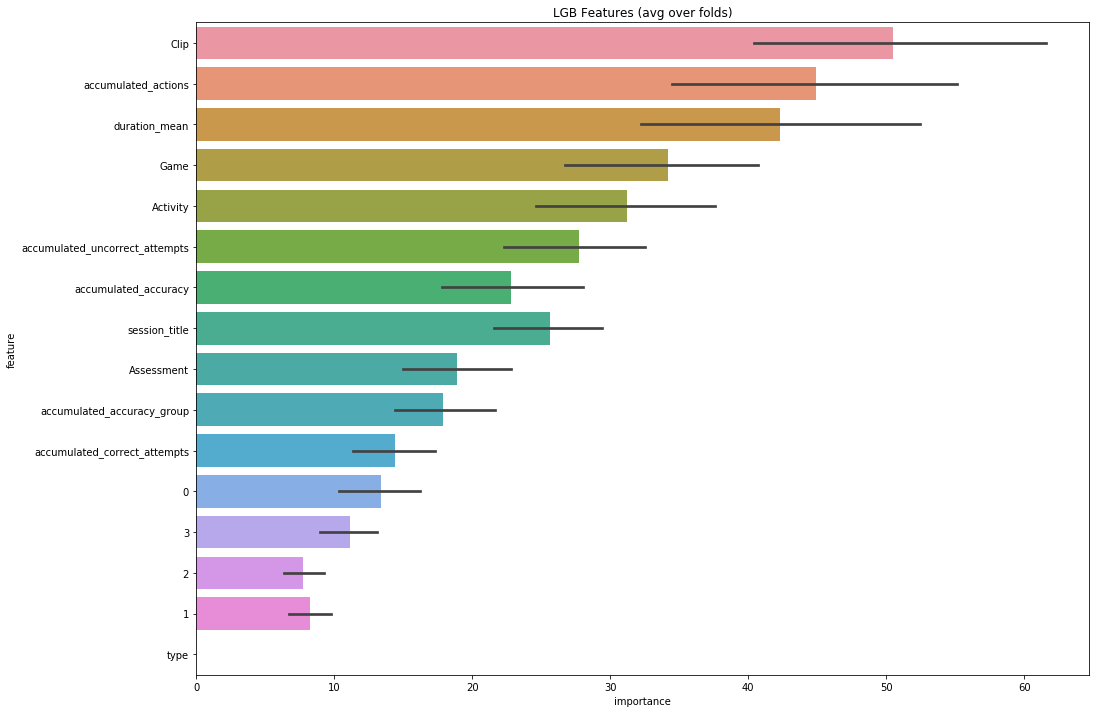

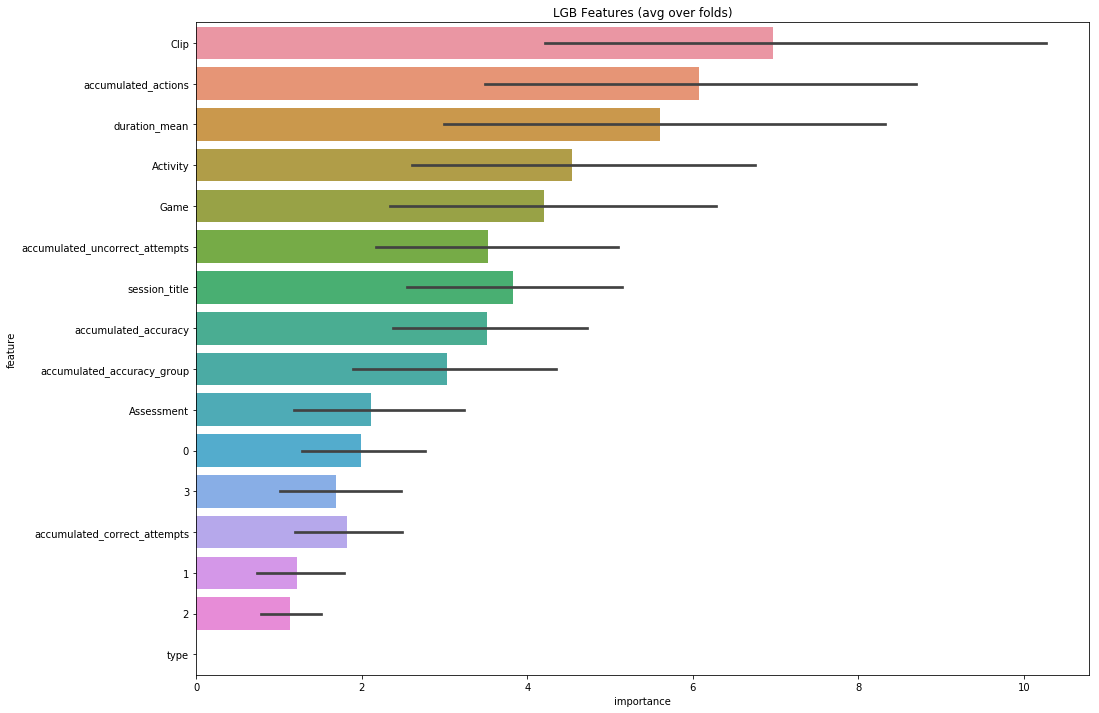

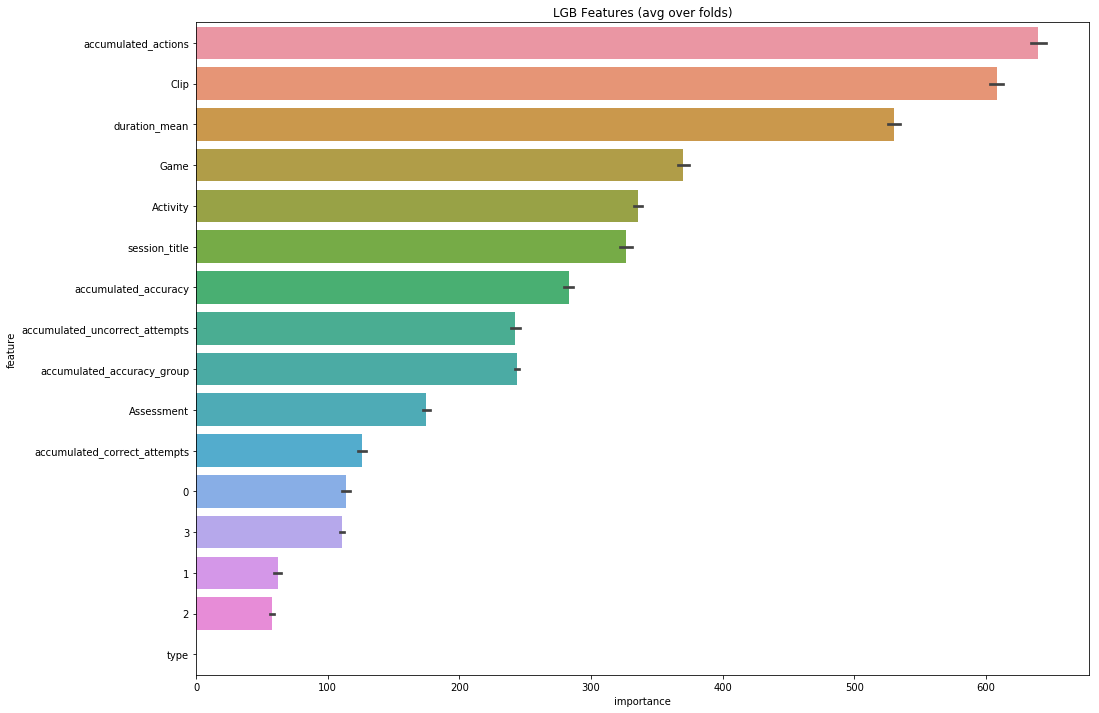

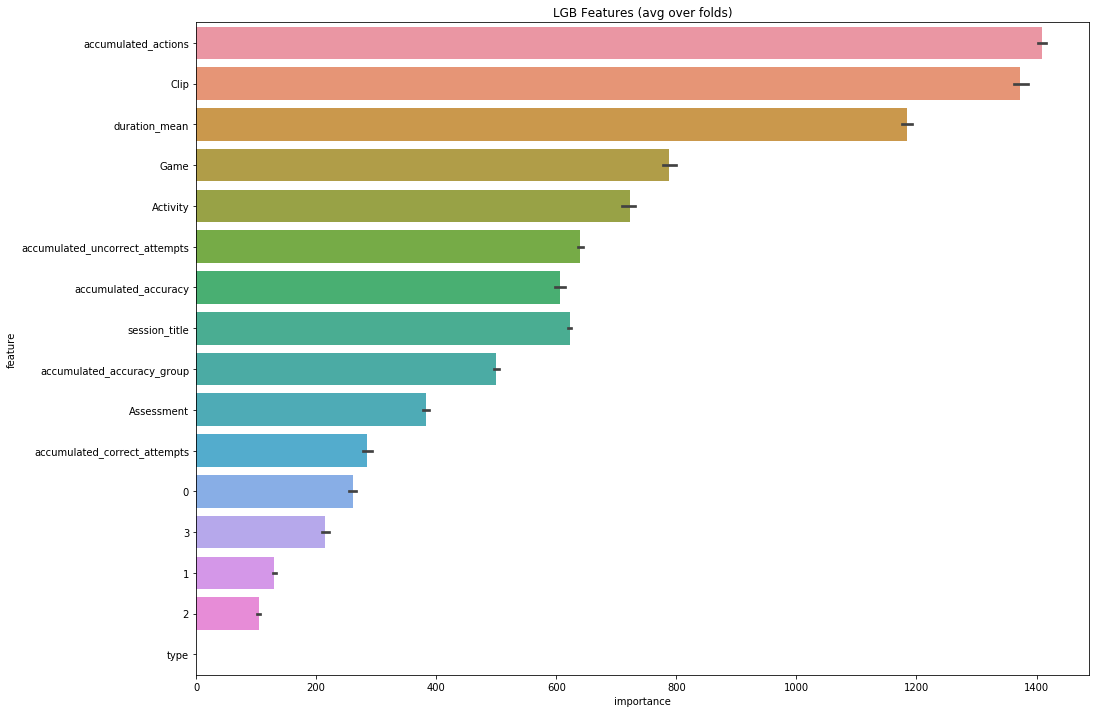

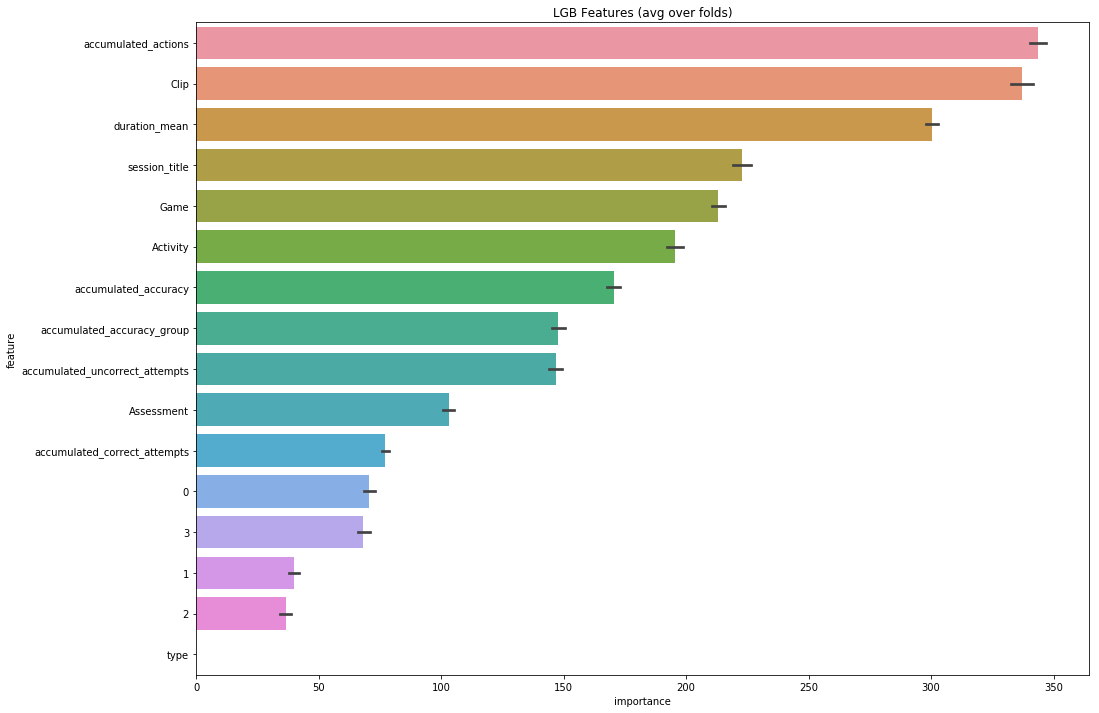

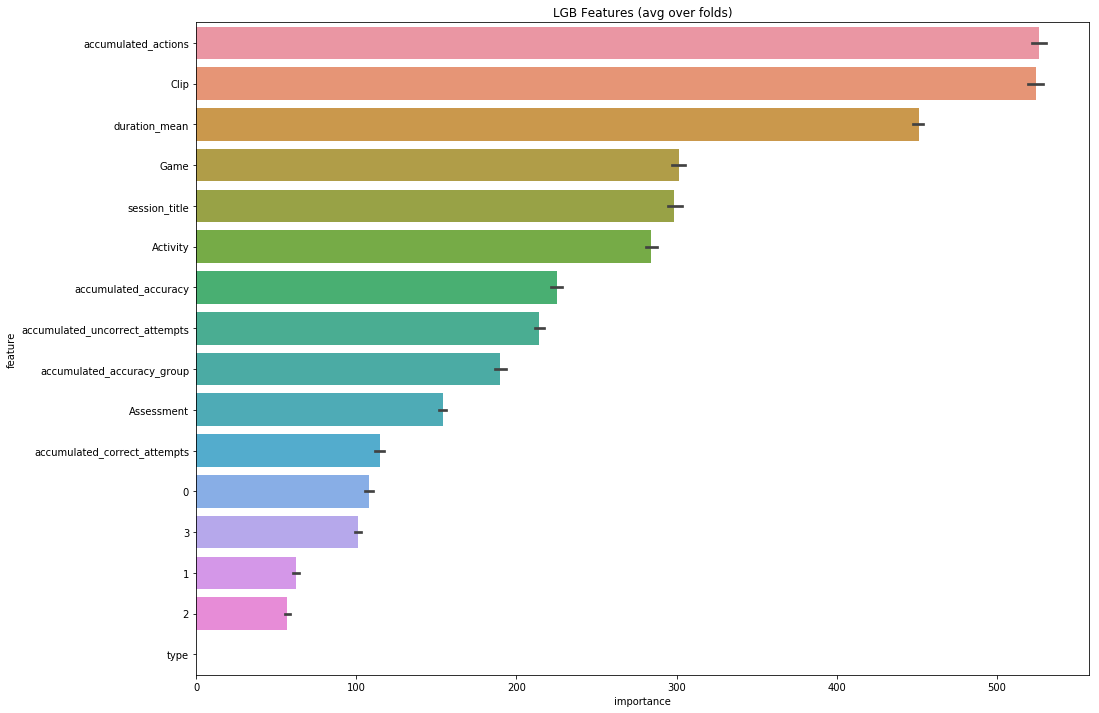

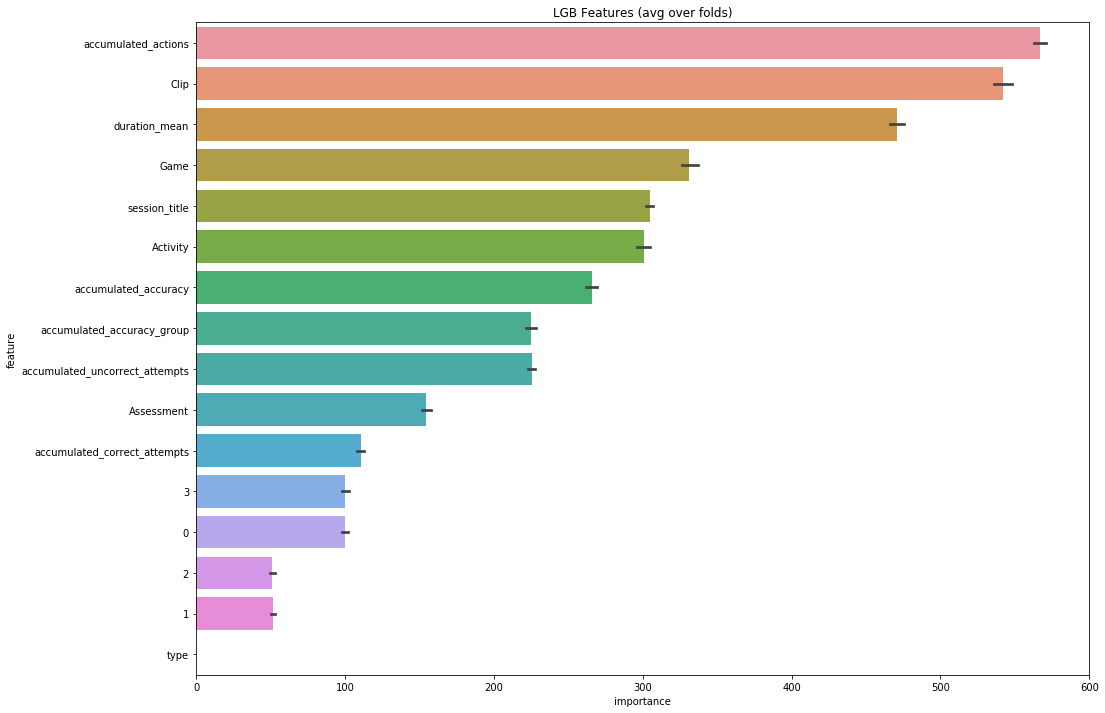

In [35]:
if __name__ == "__main__":
    study = optuna.create_study()
    study.optimize(objective, n_trials=10)
    print("params_{}".format(study.best_params))
    print("value_{}".format(study.best_value))

# Set optimized hyper parameters and Run

In [ ]:
#Set hyper parameters
params = {'num_leaves': 19,
          'min_child_samples': 314,
          'objective': 'regression',  #I will check it.
          'max_depth': 9,
          'learning_rate': 0.1945,
          "boosting_type": "gbdt",
          "max_bin":64, 
          "min_data_in_leaf":40,
          "subsample_freq": 1,
          "subsample": 0.842,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          #'reg_alpha': 0.8,
          #'reg_lambda': 0.2,
          #'colsample_bytree': 0.6
          'lambda_l1': 0.8,
          'lambda_l2': 0.2,
          'feature_fraction': 0.9838,
         }

In [ ]:
#Run
CV_score = 0

for t in new_train['type'].unique():
    type_ = t
    print(f'\nTraining of type {t}: {type_}.')
    index_type = (new_train['type'] == t)
    index_type_test = (new_test['type'] == t)
    
    X_t = x_train.loc[index_type].copy()
    X_test_t = x_test.loc[index_type_test].copy()
    y_t = y_train[index_type]

    
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=folds, 
                                              model_type='lgb', 
                                              eval_metric='mae', 
                                              plot_feature_importance=True,
                                              verbose=500, early_stopping_rounds=200, 
                                              n_estimators=n_estimators[t-1])
    del X_t, X_test_t
    gc.collect()
    
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
    ## manually computing the cv score
    CV_score += np.log(np.array(result_dict_lgb['scores']).mean())/8 # total 8 types

In [ ]:
result = pd.DataFrame({"y_train":new_train["accuracy_group"],
                      "y_pred":result_dict_lgb['oof']})

In [ ]:
result.head()

In [ ]:
result["y_pred"]= np.round(result.y_pred).astype('int')
result.head()

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
kappa = cohen_kappa_score(result.y_train, result.y_pred, weights='quadratic')
print(kappa)

## Make submission

In [ ]:
submission['accuracy_group'] = np.round(result_dict_lgb['prediction']).astype('int')
submission.to_csv('submission.csv', index=None)
submission.head()

In [ ]:
submission['accuracy_group'].plot(kind='hist')

In [ ]:
train_labels['accuracy_group'].plot(kind='hist')